In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [3]:
#import data
df = pd.read_csv('Billboard_lyrics_2720.csv')
df = df.dropna()


In [4]:
# Convert to list
data = df.lyrics.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

#print(data[:1])

In [5]:
#Tokenize words and Clean-up text

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

#print(data_words[:1])


In [6]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
#print(trigram_mod[bigram_mod[data_words[0]]])


/anaconda3/lib/python3.6/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [7]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [8]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

#print(data_lemmatized[:1])

In [9]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
#print(corpus[:1])

In [11]:
id2word[0]

'absolute'

In [21]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=8, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [22]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.086*"boom" + 0.048*"drop" + 0.027*"gs" + 0.026*"wat" + 0.023*"money" + '
  '0.015*"boom_boom" + 0.014*"rack" + 0.013*"gucci" + 0.012*"bag" + '
  '0.011*"boss"'),
 (1,
  '0.060*"love" + 0.047*"girl" + 0.044*"baby" + 0.034*"be" + 0.030*"get" + '
  '0.025*"let" + 0.022*"know" + 0.022*"go" + 0.020*"not" + 0.020*"make"'),
 (2,
  '0.160*"hit" + 0.151*"booty_dew" + 0.082*"wit" + 0.040*"get" + 0.028*"drop" '
  '+ 0.023*"leg" + 0.023*"switch" + 0.023*"stop" + 0.023*"lean" + '
  '0.021*"move"'),
 (3,
  '0.017*"music" + 0.012*"record" + 0.007*"produce" + 0.007*"level" + '
  '0.007*"black" + 0.006*"write" + 0.006*"feat" + 0.006*"song" + 0.006*"drake" '
  '+ 0.005*"kanye_w"'),
 (4,
  '0.030*"partna_dem" + 0.015*"lovely_day" + 0.013*"whats_happenin" + '
  '0.012*"woo" + 0.011*"prettywing" + 0.009*"dope_chick" + '
  '0.008*"tony_montana" + 0.008*"tryna_function" + 0.007*"wop_wop" + '
  '0.007*"lemonade"'),
 (5,
  '0.042*"go" + 0.031*"groove" + 0.031*"watch" + 0.028*"let" + 0.026*"shoe" + '


__evaluation__

In [23]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.165226820769703

Coherence Score:  0.4085208834519901


In [24]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.203039 -0.072866       1        1  46.576637
7     -0.257838 -0.123807       2        1  26.362068
1     -0.268925 -0.090233       3        1  15.318537
3      0.244689 -0.115276       4        1   4.313514
0      0.212132  0.081138       5        1   2.159738
5      0.129334  0.020882       6        1   1.935939
2     -0.110885  0.380632       7        1   1.755777
4      0.254532 -0.080470       8        1   1.577785, topic_info=      Category          Freq                 Term         Total  loglift  \
term                                                                       
71     Default  19590.000000                  get  19590.000000  30.0000   
77     Default   8579.000000                   go   8579.000000  29.0000   
114    Default   6025.000000                 love   6025.000000  28.0000   
84     Default   2603.000000                  hit   2603.000000  27.0000   
73     Default   5036.000000                 girl   5036.000000  26.0000   
4      Default   4327.000000                 baby   4327.000000  25.0000   
415    Default   3516.000000                money   3516.000000  24.0000   
266    Default   4540.000000                  let   4540.000000  23.0000   
132    Default  18446.000000                  not  18446.000000  22.0000   
21808  Default   1634.000000            booty_dew   1634.000000  21.0000   
168    Default   5475.000000                    s   5475.000000  20.0000   
169    Default   5413.000000                  say   5413.000000  19.0000   
1925   Default   1152.000000                 boom   1152.000000  18.0000   
7      Default  24507.000000                   be  24507.000000  17.0000   
11     Default   4547.000000                bitch   4547.000000  16.0000   
369    Default   1250.000000                 drop   1250.000000  15.0000   
101    Default   8650.000000                 know   8650.000000  14.0000   
1577   Default    888.000000                  wit    888.000000  13.0000   
265    Default   1622.000000                leave   1622.000000  12.0000   
10     Default   1339.000000                  big   1339.000000  11.0000   
465    Default   2916.000000                wanna   2916.000000  10.0000   
49     Default   8308.000000                   do   8308.000000   9.0000   
115    Default   4662.000000                 make   4662.000000   8.0000   
287    Default    932.000000                watch    932.000000   7.0000   
194    Default   1037.000000                 stop   1037.000000   6.0000   
5      Default   3172.000000                 back   3172.000000   5.0000   
237    Default   3609.000000                  can   3609.000000   4.0000   
422    Default   3927.000000                nigga   3927.000000   3.0000   
172    Default   4006.000000                  see   4006.000000   2.0000   
68     Default   3373.000000                 fuck   3373.000000   1.0000   
...        ...           ...                  ...           ...      ...   
7548    Topic8     70.767624              wop_wop     71.597702   4.1375   
6426    Topic8     70.646881             lemonade     71.481560   4.1374   
21516   Topic8     68.712433           lol_smiley     69.548790   4.1370   
1912    Topic8     62.479816                quavo     63.309883   4.1360   
21515   Topic8     60.142006             face_lol     60.978779   4.1353   
21662   Topic8     60.112621            jerk_jerk     60.970982   4.1350   
21777   Topic8     51.571014          hotel_motel     52.407036   4.1331   
6131    Topic8     49.607979                aight     50.444115   4.1324   
15738   Topic8     44.262909           blowing_kk     45.093330   4.1306   
21201   Topic8     42.471317       massive_attack     43.318760   4.1294   
16987   Topic8     39.928722      versace_versace     40.760708   4.1285   
5029    Topic8     34.442802              errbody     35.273079   4.1253 

In [16]:
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary


__find the optimal number of topics__

In [40]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

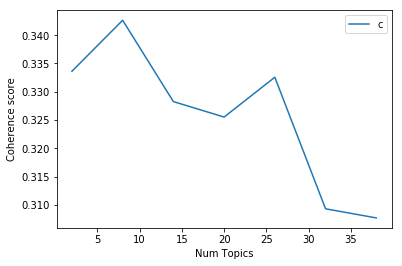

In [41]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=texts, start=2, limit=40, step=6)
# Show graph
import matplotlib.pyplot as plt
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

when the number of topics is around 8, it has the highest coherence score, so we choose 8 topics.

In [42]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3336
Num Topics = 8  has Coherence Value of 0.3426
Num Topics = 14  has Coherence Value of 0.3283
Num Topics = 20  has Coherence Value of 0.3255
Num Topics = 26  has Coherence Value of 0.3326
Num Topics = 32  has Coherence Value of 0.3093
Num Topics = 38  has Coherence Value of 0.3077


In [43]:
# Select the model and print the topics
optimal_model = model_list[1]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.036*"get" + 0.034*"be" + 0.015*"not" + 0.013*"make" + 0.012*"hit" + '
  '0.012*"money" + 0.011*"know" + 0.011*"girl" + 0.010*"do" + 0.010*"nigga"'),
 (1,
  '0.029*"be" + 0.019*"get" + 0.017*"girl" + 0.016*"know" + 0.015*"not" + '
  '0.014*"fakin" + 0.013*"come" + 0.009*"go" + 0.009*"do" + 0.007*"bitch"'),
 (2,
  '0.038*"drop" + 0.029*"partna_dem" + 0.020*"booty_dew" + 0.017*"get" + '
  '0.015*"low" + 0.011*"prettywing" + 0.010*"be" + 0.010*"go" + 0.010*"say" + '
  '0.009*"shorty_shorty"'),
 (3,
  '0.029*"get" + 0.027*"be" + 0.026*"girl" + 0.022*"go" + 0.020*"not" + '
  '0.017*"know" + 0.012*"do" + 0.010*"let" + 0.010*"money" + 0.010*"want"'),
 (4,
  '0.057*"get" + 0.035*"be" + 0.027*"not" + 0.016*"baby" + 0.013*"go" + '
  '0.012*"know" + 0.012*"do" + 0.009*"girl" + 0.007*"let" + 0.007*"love"'),
 (5,
  '0.065*"be" + 0.042*"not" + 0.021*"do" + 0.020*"get" + 0.017*"know" + '
  '0.015*"say" + 0.014*"go" + 0.009*"girl" + 0.009*"s" + 0.009*"see"'),
 (6,
  '0.050*"love" + 0.045*"not

__Finding the dominant topic in each Hip-hop lyrics__

In [44]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,5.0,0.7264,"be, not, do, get, know, say, go, girl, s, see","[Part I] [Intro: Drake] Astro, yeah Sun is do..."
1,1,6.0,0.4039,"love, not, be, feel, do, get, can, know, say, ...","[Intro] Enviyon on the mix No, no, no, no No-..."
2,2,5.0,0.6827,"be, not, do, get, know, say, go, girl, s, see",[Chorus] You prolly think that you are better...
3,3,4.0,0.5561,"get, be, not, baby, go, know, do, girl, let, love",[Intro] D.A. got that dope! [Chorus: Travis S...
4,4,5.0,0.6123,"be, not, do, get, know, say, go, girl, s, see","[Intro] Run that back, Turbo [Verse 1: Lil Ba..."
5,5,0.0,0.7812,"get, be, not, make, hit, money, know, girl, do...",[Intro] 16yrold Bitch! Daytrip took it to 10 ...
6,6,7.0,0.7759,"be, love, not, let, get, do, make, go, can, need","[Intro] Ooh, yeah, yeah [Verse 1] I put my fe..."
7,7,0.0,0.8568,"get, be, not, make, hit, money, know, girl, do...","[Intro] Yeah baby, I like it like that You go..."
8,8,4.0,0.6572,"get, be, not, baby, go, know, do, girl, let, love",[Intro: Tyga] D.A.! Hahhh! [Verse 1: Tyga] Sl...
9,9,3.0,0.3428,"get, be, girl, go, not, know, do, let, money, ...","[Intro: Drake] Trap, TrapMoneyBenny This shit..."


In [51]:
#df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 1.0]

__Find the most representative lyrics for each topic__

In [46]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.9982,"get, be, not, make, hit, money, know, girl, do...","[Intro: Cardi B & 21 Savage] Bardi in a Rari,..."
1,1.0,0.9993,"be, get, girl, know, not, fakin, come, go, do,...","1. Tuscan Leather (A. Graham, A. Palman, N. S..."
2,2.0,0.9676,"drop, partna_dem, booty_dew, get, low, prettyw...",Http://genius.com/August-alsina-i-luv-this-sh...
3,3.0,0.9974,"get, be, girl, go, not, know, do, let, money, ...",Ohhh o ohhh yeaaa yeaaa Roscoeee Shout out to...
4,4.0,0.9984,"get, be, not, baby, go, know, do, girl, let, love",[Chorus] I aint worried bout nothin (nothin) ...
5,5.0,0.9981,"be, not, do, get, know, say, go, girl, s, see","[Intro] They dont know They dont, they dont k..."
6,6.0,0.9973,"love, not, be, feel, do, get, can, know, say, ...","[Erykah Badu] Whatsa matter, is he drunk? (I ..."
7,7.0,0.9973,"be, love, not, let, get, do, make, go, can, need",Pitbull Me not working hard? Yeah right pictu...


__Topic distribution across lyrics__

In [74]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']].drop_duplicates()
topic_num_keywords.index = range(8)

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,5.0,"be, not, do, get, know, say, go, girl, s, see",239,0.1086
1,6.0,"love, not, be, feel, do, get, can, know, say, ...",57,0.0259
2,4.0,"get, be, not, baby, go, know, do, girl, let, love",18,0.0082
3,0.0,"get, be, not, make, hit, money, know, girl, do...",267,0.1213
4,7.0,"be, love, not, let, get, do, make, go, can, need",457,0.2076
5,3.0,"get, be, girl, go, not, know, do, let, money, ...",773,0.3512
6,1.0,"be, get, girl, know, not, fakin, come, go, do,...",216,0.0981
7,2.0,"drop, partna_dem, booty_dew, get, low, prettyw...",174,0.0791
